# PubMedQA Generation - Baseline Metrics Analysis

This notebook analyzes the baseline performance of `pubmedqa_generation` task without schema constraints.


In [20]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Set style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


## 1. Load Baseline Results


In [2]:
# Load baseline result JSON
baseline_result_file = "pubmedqa_baseline_2025-12-02T17-10-15.514633.json"

with open(baseline_result_file, 'r') as f:
    baseline_results = json.load(f)

# Extract exact match score
exact_match_score = baseline_results['results']['pubmedqa_generation']['exact_match,strict-match']
exact_match_stderr = baseline_results['results']['pubmedqa_generation']['exact_match_stderr,strict-match']

print("="*60)
print("BASELINE PERFORMANCE METRICS")
print("="*60)
print(f"Exact Match Score: {exact_match_score:.4f} ± {exact_match_stderr:.4f}")
print(f"Exact Match Percentage: {exact_match_score*100:.2f}%")
print("="*60)


BASELINE PERFORMANCE METRICS
Exact Match Score: 0.7620 ± 0.0191
Exact Match Percentage: 76.20%


### Answer Distribution Analysis


In [3]:
# Load baseline samples
baseline_samples_file = "samples_pubmedqa_generation_baseline.jsonl"

baseline_answers = []
baseline_responses = []
baseline_filtered_responses = []

with open(baseline_samples_file, 'r') as f:
    for line in f:
        sample = json.loads(line)
        # Get filtered response (extracted answer)
        filtered_resp = sample.get('filtered_resps', ['[invalid]'])[0]
        # Get raw response
        raw_resp = sample.get('resps', [[None]])[0][0] if sample.get('resps') else None
        
        # Normalize the answer
        answer = filtered_resp.lower().strip() if filtered_resp else '[invalid]'
        if answer not in ['yes', 'no', 'maybe']:
            answer = '[invalid]'
        
        baseline_answers.append(answer)
        baseline_responses.append(raw_resp if raw_resp else '')
        baseline_filtered_responses.append(filtered_resp if filtered_resp else '[invalid]')

# Count occurrences
answer_counts = Counter(baseline_answers)

# Prepare data for plotting
categories = ['yes', 'no', 'maybe', '[invalid]']
counts = [answer_counts.get(cat, 0) for cat in categories]

print("="*60)
print("ANSWER DISTRIBUTION")
print("="*60)
for cat, count in zip(categories, counts):
    percentage = count / len(baseline_answers) * 100 if len(baseline_answers) > 0 else 0
    print(f"  {cat:12s}: {count:4d} ({percentage:5.2f}%)")
print(f"\nTotal samples: {len(baseline_answers)}")
print(f"Valid answers (yes+no+maybe): {sum(counts[:3])} ({sum(counts[:3])/len(baseline_answers)*100:.2f}%)")
print(f"Invalid answers: {counts[3]} ({counts[3]/len(baseline_answers)*100:.2f}%)")
print("="*60)


ANSWER DISTRIBUTION
  yes         :  344 (68.80%)
  no          :  151 (30.20%)
  maybe       :    2 ( 0.40%)
  [invalid]   :    3 ( 0.60%)

Total samples: 500
Valid answers (yes+no+maybe): 497 (99.40%)
Invalid answers: 3 (0.60%)


Data verification before plotting:
  yes: 344
  no: 151
  maybe: 2
  [invalid]: 3
Total: 500


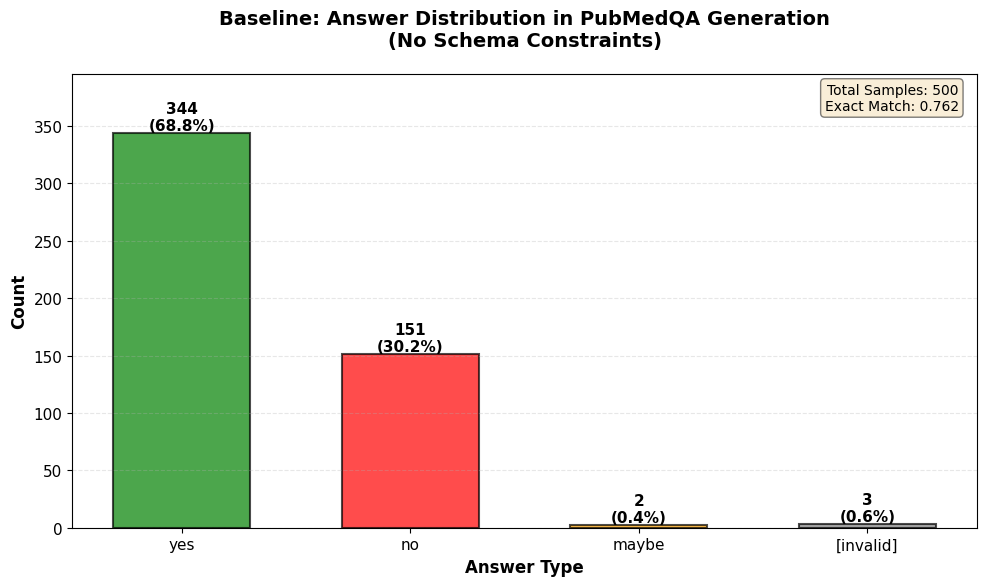

In [23]:
# Create bar chart for answer distribution
# Re-verify data to ensure correctness
answer_counts_verify = Counter(baseline_answers)
categories_plot = ['yes', 'no', 'maybe', '[invalid]']
counts_plot = [answer_counts_verify.get(cat, 0) for cat in categories_plot]

print("Data verification before plotting:")
for cat, cnt in zip(categories_plot, counts_plot):
    print(f"  {cat}: {cnt}")
print(f"Total: {sum(counts_plot)}")

fig, ax = plt.subplots(figsize=(10, 6))

# Use numeric positions for x-axis to ensure correct alignment
x_pos = np.arange(len(categories_plot))
colors = ['green', 'red', 'orange', 'gray']

# Create bars with explicit positions and verified data
bars = ax.bar(x_pos, counts_plot, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5, width=0.6)

# Add value labels on top of bars
for i, (bar, count, cat) in enumerate(zip(bars, counts_plot, categories_plot)):
    height = bar.get_height()
    percentage = count / len(baseline_answers) * 100 if len(baseline_answers) > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Set x-axis labels
ax.set_xlabel('Answer Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Baseline: Answer Distribution in PubMedQA Generation\n(No Schema Constraints)', 
          fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(categories_plot, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Set y-axis to show all values clearly
if counts_plot:
    ax.set_ylim(0, max(counts_plot) * 1.15)

# Add total count annotation
ax.text(0.98, 0.98, f'Total Samples: {len(baseline_answers)}\nExact Match: {exact_match_score:.3f}', 
         transform=ax.transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


### Response Quality Analysis


In [5]:
# Analyze response lengths and quality
response_lengths = [len(str(resp)) for resp in baseline_responses if resp]
filtered_lengths = [len(str(resp)) for resp in baseline_filtered_responses if resp]

print("="*60)
print("RESPONSE QUALITY METRICS")
print("="*60)
print(f"Total samples: {len(baseline_answers)}")
print(f"Samples with raw responses: {len([r for r in baseline_responses if r])}")
print(f"Samples with filtered responses: {len([r for r in baseline_filtered_responses if r and r != '[invalid]'])}")
print()

if response_lengths:
    print("Raw Response Length Statistics:")
    print(f"  Mean: {np.mean(response_lengths):.1f} characters")
    print(f"  Median: {np.median(response_lengths):.1f} characters")
    print(f"  Min: {np.min(response_lengths)} characters")
    print(f"  Max: {np.max(response_lengths)} characters")
    print(f"  Std: {np.std(response_lengths):.1f} characters")
    print()

if filtered_lengths:
    print("Filtered Response Length Statistics:")
    print(f"  Mean: {np.mean(filtered_lengths):.1f} characters")
    print(f"  Median: {np.median(filtered_lengths):.1f} characters")
    print(f"  Min: {np.min(filtered_lengths)} characters")
    print(f"  Max: {np.max(filtered_lengths)} characters")
    print()

# Check for common patterns in invalid responses
invalid_samples = [i for i, ans in enumerate(baseline_answers) if ans == '[invalid]']
print(f"Invalid response count: {len(invalid_samples)}")
if invalid_samples:
    print("\nSample invalid responses (first 5):")
    for idx in invalid_samples[:5]:
        print(f"  Sample {idx}: {baseline_filtered_responses[idx][:100]}")
print("="*60)


RESPONSE QUALITY METRICS
Total samples: 500
Samples with raw responses: 500
Samples with filtered responses: 497

Raw Response Length Statistics:
  Mean: 94.4 characters
  Median: 11.0 characters
  Min: 7 characters
  Max: 1471 characters
  Std: 279.1 characters

Filtered Response Length Statistics:
  Mean: 2.7 characters
  Median: 3.0 characters
  Min: 2 characters
  Max: 9 characters

Invalid response count: 3

Sample invalid responses (first 5):
  Sample 203: [invalid]
  Sample 262: [invalid]
  Sample 362: [invalid]


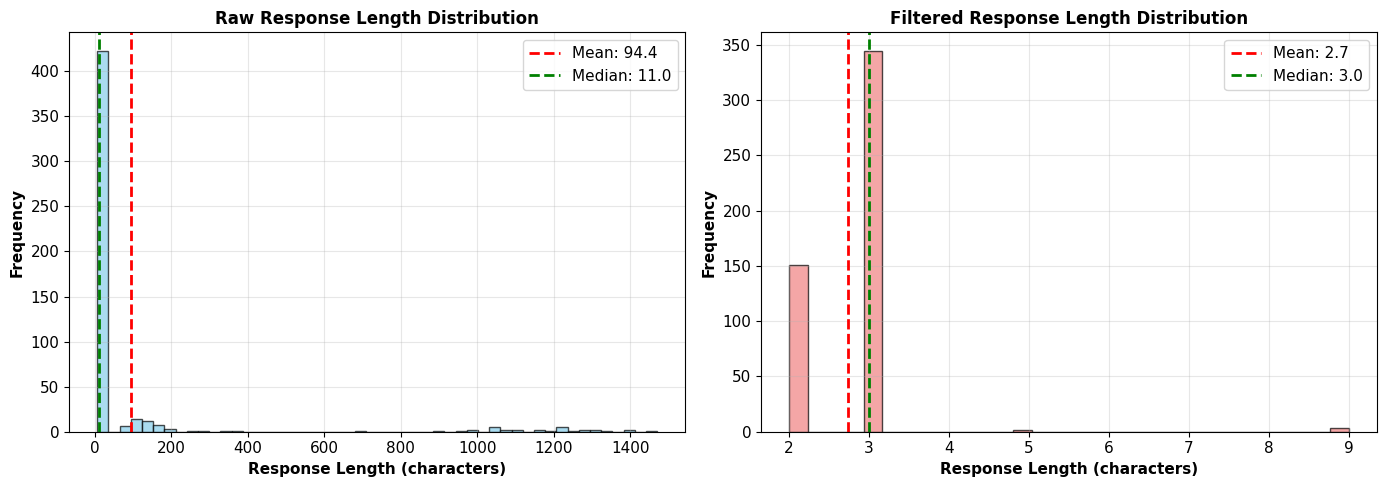

In [6]:
# Visualize response length distribution
if response_lengths:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Raw response lengths
    ax1.hist(response_lengths, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    ax1.axvline(np.mean(response_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(response_lengths):.1f}')
    ax1.axvline(np.median(response_lengths), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(response_lengths):.1f}')
    ax1.set_xlabel('Response Length (characters)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Raw Response Length Distribution', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Filtered response lengths
    if filtered_lengths:
        ax2.hist(filtered_lengths, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
        ax2.axvline(np.mean(filtered_lengths), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(filtered_lengths):.1f}')
        ax2.axvline(np.median(filtered_lengths), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(filtered_lengths):.1f}')
        ax2.set_xlabel('Response Length (characters)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax2.set_title('Filtered Response Length Distribution', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


### Summary Statistics


In [7]:
print("="*80)
print("BASELINE PERFORMANCE SUMMARY")
print("="*80)
print(f"\n📊 Task Performance:")
print(f"   • Exact Match Score: {exact_match_score:.4f} ± {exact_match_stderr:.4f}")
print(f"   • Exact Match Rate: {exact_match_score*100:.2f}%")
print(f"   • This means {int(exact_match_score * len(baseline_answers))} out of {len(baseline_answers)} samples matched correctly")

print(f"\n📈 Answer Distribution:")
print(f"   • Valid answers (yes/no/maybe): {sum(counts[:3])} ({sum(counts[:3])/len(baseline_answers)*100:.2f}%)")
print(f"   • Invalid/Unmatched answers: {counts[3]} ({counts[3]/len(baseline_answers)*100:.2f}%)")
print(f"   • Yes: {counts[0]} ({counts[0]/len(baseline_answers)*100:.2f}%)")
print(f"   • No: {counts[1]} ({counts[1]/len(baseline_answers)*100:.2f}%)")
print(f"   • Maybe: {counts[2]} ({counts[2]/len(baseline_answers)*100:.2f}%)")

print(f"\n💡 Key Insights:")
print(f"   • The baseline achieves {exact_match_score*100:.2f}% exact match accuracy")
print(f"   • {counts[3]/len(baseline_answers)*100:.2f}% of responses could not be matched by the regex filter")
print(f"   • The model shows a strong bias toward 'yes' answers ({counts[0]/len(baseline_answers)*100:.2f}%)")
if counts[1] == 0:
    print(f"   • ⚠️  The model never answered 'no' in the filtered responses")
print("="*80)


BASELINE PERFORMANCE SUMMARY

📊 Task Performance:
   • Exact Match Score: 0.7620 ± 0.0191
   • Exact Match Rate: 76.20%
   • This means 381 out of 500 samples matched correctly

📈 Answer Distribution:
   • Valid answers (yes/no/maybe): 497 (99.40%)
   • Invalid/Unmatched answers: 3 (0.60%)
   • Yes: 344 (68.80%)
   • No: 151 (30.20%)
   • Maybe: 2 (0.40%)

💡 Key Insights:
   • The baseline achieves 76.20% exact match accuracy
   • 0.60% of responses could not be matched by the regex filter
   • The model shows a strong bias toward 'yes' answers (68.80%)


## 2. Level 1 Schema Analysis

In [9]:
# Load L1 result JSON (if available)
import os 

l1_result_files = [f for f in os.listdir('.') if 'level1' in f.lower() or ('L1' in f and f.endswith('.json'))]
if l1_result_files:
    l1_result_file = l1_result_files[0]
    with open(l1_result_file, 'r') as f:
        l1_results = json.load(f)
    l1_exact_match = l1_results['results']['pubmedqa_generation']['exact_match,strict-match']
    l1_exact_match_stderr = l1_results['results']['pubmedqa_generation']['exact_match_stderr,strict-match']
    print(f"L1 Exact Match Score: {l1_exact_match:.4f} ± {l1_exact_match_stderr:.4f}")
else:
    print("L1 result JSON file not found. Will calculate from samples.")
    l1_exact_match = None
    l1_exact_match_stderr = None


L1 Exact Match Score: 0.5480 ± 0.0223


In [11]:
# Load L1 samples and extract data
l1_samples_file = "samples_pubmedqa_generation_L1.jsonl"

l1_answers = []
l1_valid_json = []
l1_has_answer = []
l1_answer_valid = []
l1_responses = []
l1_filtered_responses = []

with open(l1_samples_file, 'r') as f:
    for line in f:
        sample = json.loads(line)
        
        # Get raw response (first element of first list)
        raw_resp = sample.get('resps', [[None]])[0][0] if sample.get('resps') else None
        filtered_resp = sample.get('filtered_resps', ['[invalid]'])[0]
        
        # Try to parse JSON from raw response
        json_valid = False
        answer = None
        has_answer_field = False
        answer_is_valid_enum = False
        
        if raw_resp and isinstance(raw_resp, str):
            text_cleaned = raw_resp.strip()
            
            # Helper function to extract JSON by finding matching braces
            def extract_json_from_text(text):
                # Try direct parse first (most common case)
                try:
                    return json.loads(text)
                except (json.JSONDecodeError, TypeError):
                    pass
                
                # Try to find complete JSON object using balanced braces
                start_idx = text.find('{')
                if start_idx == -1:
                    return None
                
                # Count braces to find the matching closing brace
                brace_count = 0
                for i in range(start_idx, len(text)):
                    if text[i] == '{':
                        brace_count += 1
                    elif text[i] == '}':
                        brace_count -= 1
                        if brace_count == 0:
                            # Found matching closing brace
                            json_str = text[start_idx:i+1]
                            try:
                                return json.loads(json_str)
                            except (json.JSONDecodeError, TypeError):
                                return None
                return None
            
            # Extract and parse JSON
            parsed = extract_json_from_text(text_cleaned)
            if parsed and isinstance(parsed, dict):
                json_valid = True
                answer = parsed.get('answer', '').lower().strip() if parsed.get('answer') else None
                has_answer_field = answer is not None
                answer_is_valid_enum = answer in ['yes', 'no', 'maybe']
        
        # If JSON parsing failed, fallback to filtered_resp for answer
        if not json_valid:
            answer = filtered_resp.lower().strip() if filtered_resp else '[invalid]'
        
        # Normalize answer
        if answer not in ['yes', 'no', 'maybe']:
            answer = '[invalid]'
        
        l1_answers.append(answer)
        l1_valid_json.append(json_valid)
        l1_has_answer.append(has_answer_field)
        l1_answer_valid.append(answer_is_valid_enum)
        l1_responses.append(raw_resp if raw_resp else '')
        l1_filtered_responses.append(filtered_resp if filtered_resp else '[invalid]')

# Count occurrences
l1_answer_counts = Counter(l1_answers)
l1_categories = ['yes', 'no', 'maybe', '[invalid]']
l1_counts = [l1_answer_counts.get(cat, 0) for cat in l1_categories]

# Calculate schema compliance
l1_total = len(l1_answers)
l1_valid_json_count = sum(l1_valid_json)
l1_compliant = sum([l1_valid_json[i] and l1_has_answer[i] and l1_answer_valid[i] 
                    for i in range(l1_total)])

print("="*60)
print("L1 SCHEMA ANALYSIS")
print("="*60)
print(f"\nAnswer Distribution:")
for cat, count in zip(l1_categories, l1_counts):
    percentage = count / l1_total * 100 if l1_total > 0 else 0
    print(f"  {cat:12s}: {count:4d} ({percentage:5.2f}%)")
print(f"\nTotal samples: {l1_total}")
print(f"Valid answers (yes+no+maybe): {sum(l1_counts[:3])} ({sum(l1_counts[:3])/l1_total*100:.2f}%)")
print(f"Invalid answers: {l1_counts[3]} ({l1_counts[3]/l1_total*100:.2f}%)")

print(f"\nJSON Validity:")
print(f"  Valid JSON: {l1_valid_json_count}/{l1_total} ({l1_valid_json_count/l1_total*100:.2f}%)")
print(f"  Invalid JSON: {l1_total - l1_valid_json_count}/{l1_total} ({(l1_total - l1_valid_json_count)/l1_total*100:.2f}%)")

print(f"\nSchema Compliance:")
print(f"  Compliant (valid JSON + has answer + valid enum): {l1_compliant}/{l1_total} ({l1_compliant/l1_total*100:.2f}%)")
print(f"  Non-compliant: {l1_total - l1_compliant}/{l1_total} ({(l1_total - l1_compliant)/l1_total*100:.2f}%)")
print("="*60)


L1 SCHEMA ANALYSIS

Answer Distribution:
  yes         :  248 (49.60%)
  no          :  101 (20.20%)
  maybe       :    0 ( 0.00%)
  [invalid]   :  151 (30.20%)

Total samples: 500
Valid answers (yes+no+maybe): 349 (69.80%)
Invalid answers: 151 (30.20%)

JSON Validity:
  Valid JSON: 349/500 (69.80%)
  Invalid JSON: 151/500 (30.20%)

Schema Compliance:
  Compliant (valid JSON + has answer + valid enum): 349/500 (69.80%)
  Non-compliant: 151/500 (30.20%)


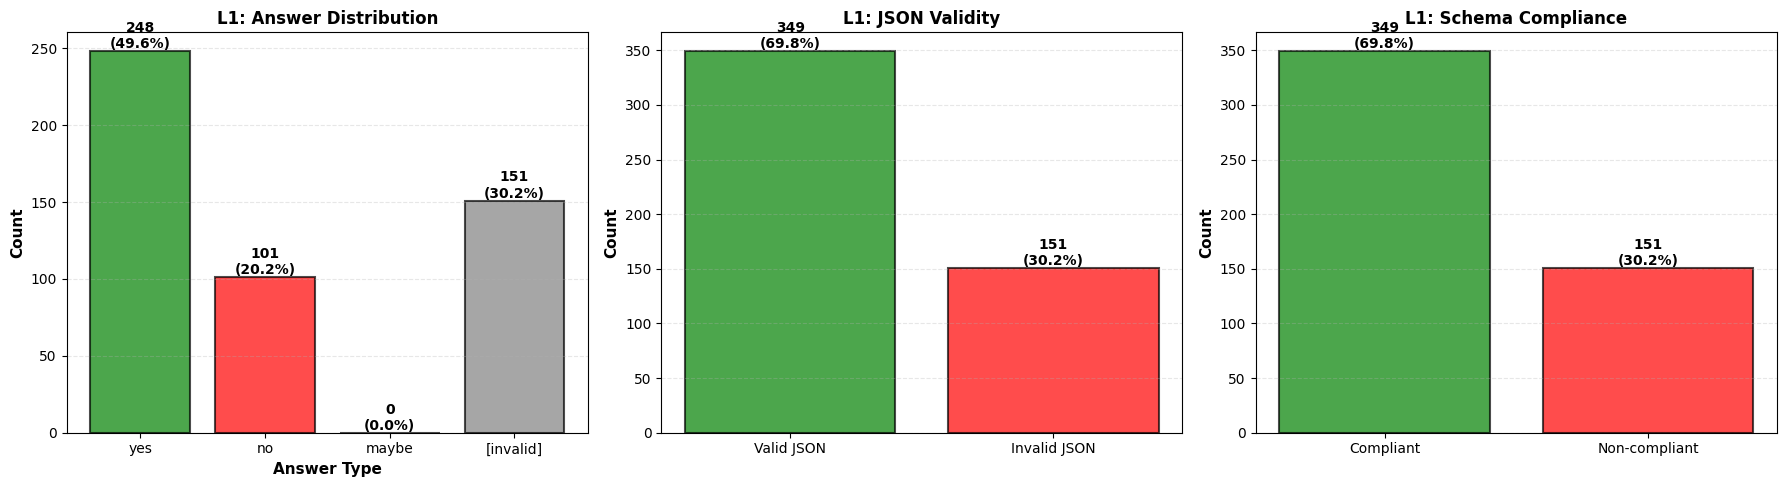

In [12]:
# Create visualizations for L1
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Answer Distribution
ax1 = axes[0]
bars1 = ax1.bar(l1_categories, l1_counts, color=['green', 'red', 'orange', 'gray'], alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars1, l1_counts):
    height = bar.get_height()
    percentage = count / l1_total * 100 if l1_total > 0 else 0
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax1.set_xlabel('Answer Type', fontsize=11, fontweight='bold')
ax1.set_ylabel('Count', fontsize=11, fontweight='bold')
ax1.set_title('L1: Answer Distribution', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=10)

# 2. JSON Validity
ax2 = axes[1]
valid_count = l1_valid_json_count
invalid_count = l1_total - l1_valid_json_count
bars2 = ax2.bar(['Valid JSON', 'Invalid JSON'], [valid_count, invalid_count], 
                color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars2, [valid_count, invalid_count]):
    height = bar.get_height()
    percentage = count / l1_total * 100 if l1_total > 0 else 0
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_ylabel('Count', fontsize=11, fontweight='bold')
ax2.set_title('L1: JSON Validity', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=10)

# 3. Schema Compliance
ax3 = axes[2]
compliant_count = l1_compliant
non_compliant_count = l1_total - l1_compliant
bars3 = ax3.bar(['Compliant', 'Non-compliant'], [compliant_count, non_compliant_count],
                color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars3, [compliant_count, non_compliant_count]):
    height = bar.get_height()
    percentage = count / l1_total * 100 if l1_total > 0 else 0
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax3.set_ylabel('Count', fontsize=11, fontweight='bold')
ax3.set_title('L1: Schema Compliance', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.tick_params(labelsize=10)

plt.tight_layout()
plt.show()


### Baseline vs L1 Comparison


In [ ]:
# Compare Baseline vs L1
print("="*80)
print("BASELINE vs L1 COMPARISON")
print("="*80)

print(f"\n📊 Task Performance (Exact Match):")
print(f"   Baseline: {exact_match_score:.4f} ± {exact_match_stderr:.4f} ({exact_match_score*100:.2f}%)")
if l1_exact_match is not None:
    print(f"   L1:       {l1_exact_match:.4f} ± {l1_exact_match_stderr:.4f} ({l1_exact_match*100:.2f}%)")
    improvement = l1_exact_match - exact_match_score
    improvement_pct = (improvement / exact_match_score * 100) if exact_match_score > 0 else 0
    print(f"   Difference: {improvement:+.4f} ({improvement_pct:+.2f}%)")
else:
    print(f"   L1:       (calculated from samples)")

print(f"\n📈 Answer Distribution:")
print(f"   {'Metric':<20} {'Baseline':<15} {'L1':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")
# Compute baseline counts directly from baseline_answers
baseline_answer_counts = Counter(baseline_answers)
baseline_categories = ['yes', 'no', 'maybe', '[invalid]']
baseline_counts = [baseline_answer_counts.get(cat, 0) for cat in baseline_categories]
for i, cat in enumerate(baseline_categories):
    baseline_pct = baseline_counts[i] / len(baseline_answers) * 100
    l1_pct = l1_counts[i] / l1_total * 100
    diff = l1_pct - baseline_pct
    print(f"   {cat:<20} {baseline_pct:>6.2f}% ({baseline_counts[i]:>3d}) {l1_pct:>6.2f}% ({l1_counts[i]:>3d}) {diff:>+6.2f}%")

print(f"\n🔍 Schema Compliance (L1 only):")
print(f"   Valid JSON: {l1_valid_json_count}/{l1_total} ({l1_valid_json_count/l1_total*100:.2f}%)")
print(f"   Schema Compliant: {l1_compliant}/{l1_total} ({l1_compliant/l1_total*100:.2f}%)")
print(f"   (Compliant = valid JSON + has answer field + answer is valid enum)")

print(f"\n💡 Key Insights:")
if l1_exact_match is not None:
    if l1_exact_match > exact_match_score:
        print(f"   ✅ L1 schema improves performance by {improvement*100:.2f} percentage points")
    elif l1_exact_match < exact_match_score:
        print(f"   ⚠️  L1 schema decreases performance by {abs(improvement)*100:.2f} percentage points")
    else:
        print(f"   ➡️  L1 schema has similar performance to baseline")
print(f"   • L1 has {l1_valid_json_count/l1_total*100:.2f}% valid JSON (schema-constrained output)")
print(f"   • L1 has {l1_compliant/l1_total*100:.2f}% schema compliance")
print(f"   • Baseline has no schema constraints (free-form output)")
print("="*80)


BASELINE vs L1 COMPARISON

📊 Task Performance (Exact Match):
   Baseline: 0.7620 ± 0.0191 (76.20%)
   L1:       0.5480 ± 0.0223 (54.80%)
   Difference: -0.2140 (-28.08%)

📈 Answer Distribution:
   Metric               Baseline        L1              Difference     
   -------------------- --------------- --------------- ---------------
   yes                   68.80% (344)  49.60% (248) -19.20%
   no                    30.20% (151)  20.20% (101) -10.00%
   maybe                  0.40% (  2)   0.00% (  0)  -0.40%
   [invalid]              0.60% (  3)  30.20% (151) +29.60%

🔍 Schema Compliance (L1 only):
   Valid JSON: 349/500 (69.80%)
   Schema Compliant: 349/500 (69.80%)
   (Compliant = valid JSON + has answer field + answer is valid enum)

💡 Key Insights:
   ⚠️  L1 schema decreases performance by 21.40 percentage points
   • L1 has 69.80% valid JSON (schema-constrained output)
   • L1 has 69.80% schema compliance
   • Baseline has no schema constraints (free-form output)


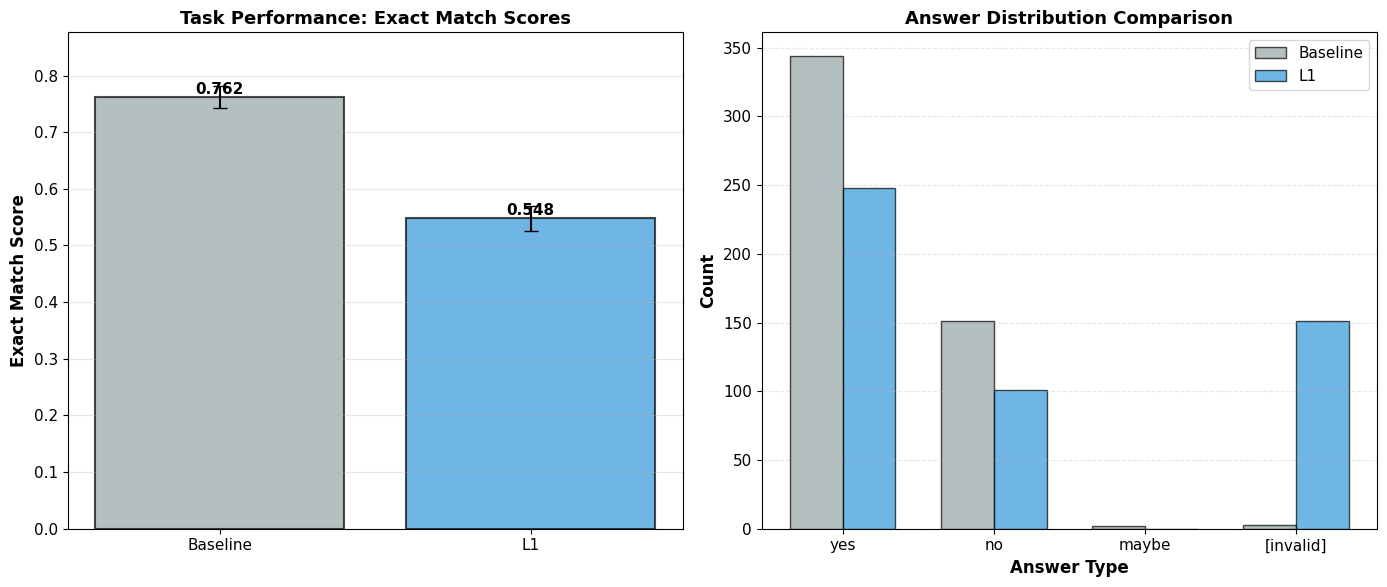

In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Exact Match Score Comparison
ax1 = axes[0]
if l1_exact_match is not None:
    scores = [exact_match_score, l1_exact_match]
    stderrs = [exact_match_stderr, l1_exact_match_stderr]
    labels = ['Baseline', 'L1']
    colors = ['#95a5a6', '#3498db']
else:
    scores = [exact_match_score]
    stderrs = [exact_match_stderr]
    labels = ['Baseline']
    colors = ['#95a5a6']

bars = ax1.bar(labels, scores, yerr=stderrs, capsize=5, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.set_ylabel('Exact Match Score', fontsize=12, fontweight='bold')
ax1.set_title('Task Performance: Exact Match Scores', fontsize=13, fontweight='bold')
ax1.set_ylim(0, max(scores) * 1.15)
ax1.grid(alpha=0.3, axis='y')
ax1.tick_params(labelsize=11)

# 2. Answer Distribution Comparison
ax2 = axes[1]
x = np.arange(len(l1_categories))
width = 0.35
bars1 = ax2.bar(x - width/2, counts, width, label='Baseline', color='#95a5a6', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x + width/2, l1_counts, width, label='L1', color='#3498db', alpha=0.7, edgecolor='black')

ax2.set_xlabel('Answer Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Answer Distribution Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(l1_categories)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=11)

plt.tight_layout()
plt.show()


### Invalid JSON Analysis for L1

In [15]:
# Analyze invalid JSON responses for L1
l1_invalid_json_indices = [i for i, valid in enumerate(l1_valid_json) if not valid]
l1_invalid_responses = [l1_responses[i] for i in l1_invalid_json_indices]

print("="*80)
print("INVALID JSON RESPONSE ANALYSIS (L1)")
print("="*80)
print(f"Total invalid JSON responses: {len(l1_invalid_json_indices)}")
print(f"Percentage of total: {len(l1_invalid_json_indices)/l1_total*100:.2f}%")
print()

# Categorize invalid responses
invalid_categories = {
    'empty': [],
    'incomplete_json': [],  # Starts with { but incomplete
    'no_json': [],  # No { found
    'malformed_json': [],  # Has { but can't parse
    'other': []
}

for idx in l1_invalid_json_indices:
    resp = l1_responses[idx]
    if not resp or resp.strip() == '':
        invalid_categories['empty'].append((idx, resp))
    elif resp.strip().startswith('{'):
        # Check if it's incomplete (no closing brace or malformed)
        text_cleaned = resp.strip()
        if not text_cleaned.rstrip().endswith('}'):
            invalid_categories['incomplete_json'].append((idx, resp))
        else:
            invalid_categories['malformed_json'].append((idx, resp))
    elif '{' not in resp:
        invalid_categories['no_json'].append((idx, resp))
    else:
        invalid_categories['other'].append((idx, resp))

print("Invalid JSON Categories:")
for category, samples in invalid_categories.items():
    print(f"  {category:20s}: {len(samples):4d} ({len(samples)/len(l1_invalid_json_indices)*100:.1f}% of invalid)")
print()

# Show examples from each category
print("="*80)
print("EXAMPLES OF INVALID JSON RESPONSES")
print("="*80)

for category, samples in invalid_categories.items():
    if samples:
        print(f"\n{category.upper().replace('_', ' ')} ({len(samples)} samples):")
        print("-" * 80)
        # Show first 3 examples
        for i, (idx, resp) in enumerate(samples[:3]):
            print(f"\nExample {i+1} (Sample {idx}):")
            print(f"Length: {len(str(resp))} characters")
            print(f"First 200 chars: {repr(str(resp)[:200])}")
            if len(str(resp)) > 200:
                print(f"... (truncated, total length: {len(str(resp))} chars)")
        if len(samples) > 3:
            print(f"\n... and {len(samples) - 3} more samples")
print("="*80)


INVALID JSON RESPONSE ANALYSIS (L1)
Total invalid JSON responses: 151
Percentage of total: 30.20%

Invalid JSON Categories:
  empty               :    0 (0.0% of invalid)
  incomplete_json     :  151 (100.0% of invalid)
  no_json             :    0 (0.0% of invalid)
  malformed_json      :    0 (0.0% of invalid)
  other               :    0 (0.0% of invalid)

EXAMPLES OF INVALID JSON RESPONSES

INCOMPLETE JSON (151 samples):
--------------------------------------------------------------------------------

Example 1 (Sample 0):
Length: 2426 characters
First 200 chars: '{  \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n        \n         \n      '
... (truncated, total length: 2426 chars)

Example 2 (Sample 2):
Length: 2426 characters
First 200 chars: '{  \n        \n         \n        \n         \n        \n         \n        \n         \n      

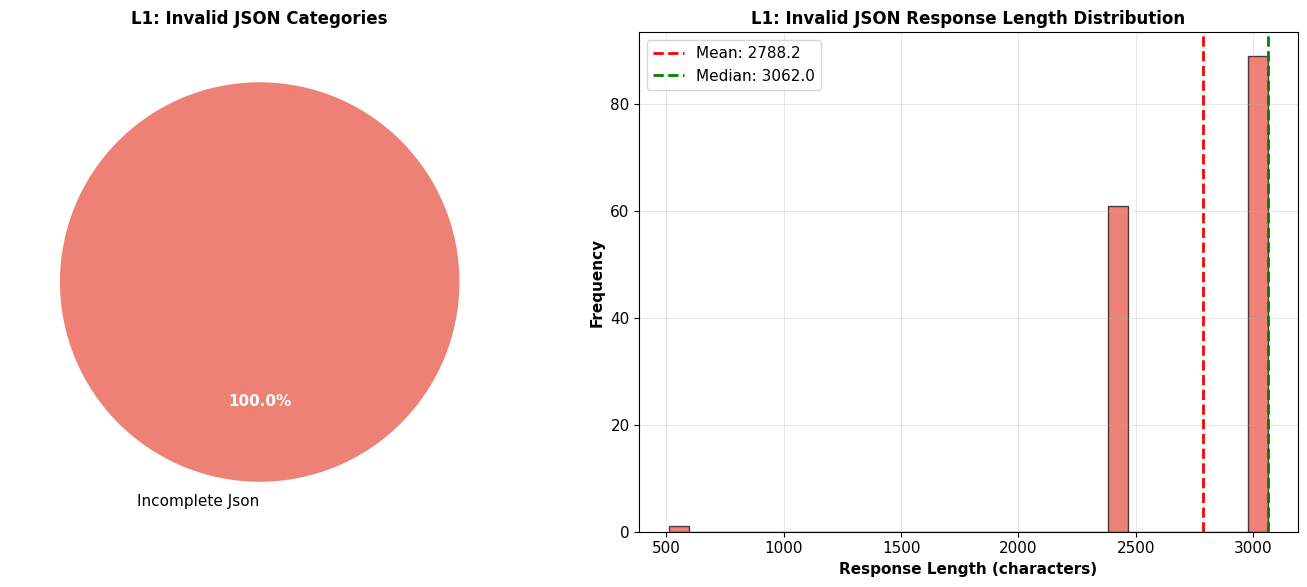

In [16]:
# Visualize invalid JSON categories
if l1_invalid_json_indices:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Pie chart of invalid JSON categories
    ax1 = axes[0]
    category_names = [cat.replace('_', ' ').title() for cat in invalid_categories.keys()]
    category_counts = [len(samples) for samples in invalid_categories.values()]
    colors_pie = ['#e74c3c', '#f39c12', '#9b59b6', '#3498db', '#95a5a6']
    
    # Only show categories with samples
    non_zero_categories = [(name, count) for name, count in zip(category_names, category_counts) if count > 0]
    if non_zero_categories:
        names, counts = zip(*non_zero_categories)
        wedges, texts, autotexts = ax1.pie(counts, labels=names, autopct='%1.1f%%', 
                                          startangle=90, colors=colors_pie[:len(names)])
        for wedge in wedges:
            wedge.set_alpha(0.7)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax1.set_title('L1: Invalid JSON Categories', fontsize=12, fontweight='bold')
    
    # 2. Length distribution of invalid responses
    ax2 = axes[1]
    invalid_lengths = [len(str(l1_responses[i])) for i in l1_invalid_json_indices if l1_responses[i]]
    if invalid_lengths:
        ax2.hist(invalid_lengths, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
        ax2.axvline(np.mean(invalid_lengths), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(invalid_lengths):.1f}')
        ax2.axvline(np.median(invalid_lengths), color='green', linestyle='--', linewidth=2, 
                   label=f'Median: {np.median(invalid_lengths):.1f}')
        ax2.set_xlabel('Response Length (characters)', fontsize=11, fontweight='bold')
        ax2.set_ylabel('Frequency', fontsize=11, fontweight='bold')
        ax2.set_title('L1: Invalid JSON Response Length Distribution', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [17]:
# Detailed analysis of common patterns in invalid JSON
print("="*80)
print("DETAILED PATTERN ANALYSIS")
print("="*80)

# Analyze incomplete JSON patterns
incomplete_samples = invalid_categories['incomplete_json']
if incomplete_samples:
    print(f"\n📋 Incomplete JSON Analysis ({len(incomplete_samples)} samples):")
    print("-" * 80)
    
    # Check common patterns
    starts_with_brace = sum(1 for _, resp in incomplete_samples if resp.strip().startswith('{'))
    has_newlines = sum(1 for _, resp in incomplete_samples if '\n' in str(resp))
    has_whitespace_only = sum(1 for _, resp in incomplete_samples 
                             if resp.strip() == '{' or (resp.strip().startswith('{') and 
                                 len(resp.strip().replace('{', '').replace('\n', '').replace(' ', '')) < 5))
    
    print(f"  • Starts with '{{': {starts_with_brace}/{len(incomplete_samples)}")
    print(f"  • Contains newlines: {has_newlines}/{len(incomplete_samples)}")
    print(f"  • Mostly whitespace after '{{': {has_whitespace_only}/{len(incomplete_samples)}")
    
    # Show most common pattern
    print(f"\n  Most common pattern examples:")
    for i, (idx, resp) in enumerate(incomplete_samples[:5]):
        cleaned = resp.strip()[:100].replace('\n', '\\n')
        print(f"    {i+1}. Sample {idx}: {repr(cleaned)}")

# Analyze no JSON patterns
no_json_samples = invalid_categories['no_json']
if no_json_samples:
    print(f"\n📋 No JSON Found Analysis ({len(no_json_samples)} samples):")
    print("-" * 80)
    
    # Check what they contain instead
    has_text = sum(1 for _, resp in no_json_samples if resp and len(resp.strip()) > 0)
    empty_or_whitespace = sum(1 for _, resp in no_json_samples 
                             if not resp or resp.strip() == '')
    
    print(f"  • Contains text (no JSON): {has_text}/{len(no_json_samples)}")
    print(f"  • Empty or whitespace only: {empty_or_whitespace}/{len(no_json_samples)}")
    
    # Show examples
    print(f"\n  Example responses:")
    for i, (idx, resp) in enumerate(no_json_samples[:5]):
        preview = str(resp)[:150] if resp else '(empty)'
        print(f"    {i+1}. Sample {idx}: {repr(preview)}")

# Analyze malformed JSON
malformed_samples = invalid_categories['malformed_json']
if malformed_samples:
    print(f"\n📋 Malformed JSON Analysis ({len(malformed_samples)} samples):")
    print("-" * 80)
    
    # Try to identify common issues
    missing_quotes = sum(1 for _, resp in malformed_samples if '{' in resp and '"' not in resp)
    unclosed_braces = sum(1 for _, resp in malformed_samples 
                         if resp.count('{') != resp.count('}'))
    syntax_errors = len(malformed_samples) - missing_quotes - unclosed_braces
    
    print(f"  • Missing quotes: {missing_quotes}/{len(malformed_samples)}")
    print(f"  • Unclosed braces: {unclosed_braces}/{len(malformed_samples)}")
    print(f"  • Other syntax errors: {syntax_errors}/{len(malformed_samples)}")
    
    # Show examples
    print(f"\n  Example malformed JSON:")
    for i, (idx, resp) in enumerate(malformed_samples[:3]):
        print(f"    {i+1}. Sample {idx}:")
        print(f"       {repr(str(resp)[:200])}")

print("\n" + "="*80)


DETAILED PATTERN ANALYSIS

📋 Incomplete JSON Analysis (151 samples):
--------------------------------------------------------------------------------
  • Starts with '{': 151/151
  • Contains newlines: 150/151
  • Mostly whitespace after '{': 151/151

  Most common pattern examples:
    1. Sample 0: '{'
    2. Sample 2: '{'
    3. Sample 5: '{'
    4. Sample 6: '{'
    5. Sample 8: '{'



In [18]:
# Create a detailed comparison table of invalid vs valid JSON characteristics
if l1_invalid_json_indices:
    valid_json_indices = [i for i, valid in enumerate(l1_valid_json) if valid]
    valid_responses = [l1_responses[i] for i in valid_json_indices if l1_responses[i]]
    invalid_responses = [l1_responses[i] for i in l1_invalid_json_indices if l1_responses[i]]
    
    print("="*80)
    print("VALID vs INVALID JSON CHARACTERISTICS")
    print("="*80)
    
    if valid_responses:
        valid_lengths = [len(str(r)) for r in valid_responses]
        print(f"\nValid JSON Responses ({len(valid_responses)} samples):")
        print(f"  Mean length: {np.mean(valid_lengths):.1f} characters")
        print(f"  Median length: {np.median(valid_lengths):.1f} characters")
        print(f"  Min length: {np.min(valid_lengths)} characters")
        print(f"  Max length: {np.max(valid_lengths)} characters")
        print(f"  Std dev: {np.std(valid_lengths):.1f} characters")
    
    if invalid_responses:
        invalid_lengths = [len(str(r)) for r in invalid_responses]
        print(f"\nInvalid JSON Responses ({len(invalid_responses)} samples):")
        print(f"  Mean length: {np.mean(invalid_lengths):.1f} characters")
        print(f"  Median length: {np.median(invalid_lengths):.1f} characters")
        print(f"  Min length: {np.min(invalid_lengths)} characters")
        print(f"  Max length: {np.max(invalid_lengths)} characters")
        print(f"  Std dev: {np.std(invalid_lengths):.1f} characters")
        
        if valid_responses:
            print(f"\nComparison:")
            print(f"  Length difference: {np.mean(invalid_lengths) - np.mean(valid_lengths):+.1f} characters")
            print(f"  Invalid responses are {'longer' if np.mean(invalid_lengths) > np.mean(valid_lengths) else 'shorter'} on average")
    
    print("="*80)


VALID vs INVALID JSON CHARACTERISTICS

Valid JSON Responses (349 samples):
  Mean length: 15.7 characters
  Median length: 16.0 characters
  Min length: 15 characters
  Max length: 16 characters
  Std dev: 0.5 characters

Invalid JSON Responses (151 samples):
  Mean length: 2788.2 characters
  Median length: 3062.0 characters
  Min length: 512 characters
  Max length: 3062 characters
  Std dev: 362.6 characters

Comparison:
  Length difference: +2772.5 characters
  Invalid responses are longer on average


/tmp/ipykernel_1341437/3470318904.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([valid_lengths, invalid_lengths],


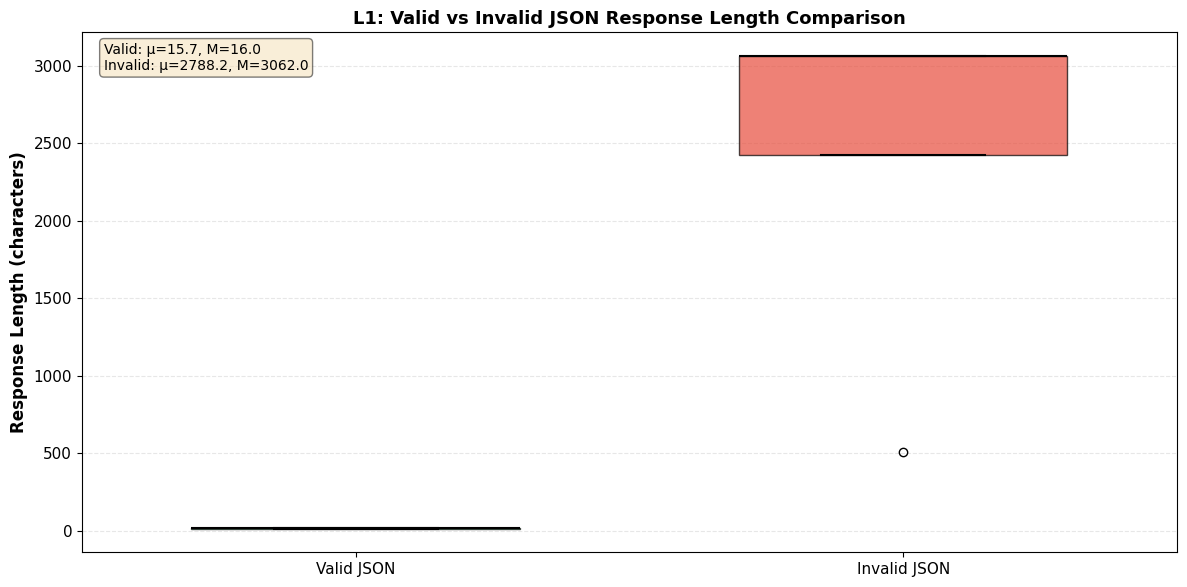

In [19]:
# Visualize valid vs invalid JSON length comparison
if l1_invalid_json_indices and l1_valid_json_count > 0:
    valid_json_indices = [i for i, valid in enumerate(l1_valid_json) if valid]
    valid_responses = [l1_responses[i] for i in valid_json_indices if l1_responses[i]]
    invalid_responses = [l1_responses[i] for i in l1_invalid_json_indices if l1_responses[i]]
    
    if valid_responses and invalid_responses:
        valid_lengths = [len(str(r)) for r in valid_responses]
        invalid_lengths = [len(str(r)) for r in invalid_responses]
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Create side-by-side box plot
        bp = ax.boxplot([valid_lengths, invalid_lengths], 
                        labels=['Valid JSON', 'Invalid JSON'],
                        patch_artist=True,
                        widths=0.6)
        
        # Color the boxes
        colors_box = ['#2ecc71', '#e74c3c']
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Style the plot
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', linewidth=1.5)
        
        ax.set_ylabel('Response Length (characters)', fontsize=12, fontweight='bold')
        ax.set_title('L1: Valid vs Invalid JSON Response Length Comparison', 
                    fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.tick_params(labelsize=11)
        
        # Add statistics text
        stats_text = f"Valid: μ={np.mean(valid_lengths):.1f}, M={np.median(valid_lengths):.1f}\n"
        stats_text += f"Invalid: μ={np.mean(invalid_lengths):.1f}, M={np.median(invalid_lengths):.1f}"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()


## Level 2 Schema Analysis


In [24]:
# Load L2 result JSON (if available)
l2_result_files = [f for f in os.listdir('.') if 'level2' in f.lower() or ('L2' in f and f.endswith('.json') and 'level' in f.lower())]
if l2_result_files:
    l2_result_file = l2_result_files[0]
    with open(l2_result_file, 'r') as f:
        l2_results = json.load(f)
    l2_exact_match = l2_results['results']['pubmedqa_generation']['exact_match,strict-match']
    l2_exact_match_stderr = l2_results['results']['pubmedqa_generation']['exact_match_stderr,strict-match']
    print(f"L2 Exact Match Score: {l2_exact_match:.4f} ± {l2_exact_match_stderr:.4f}")
else:
    print("L2 result JSON file not found. Will calculate from samples.")
    l2_exact_match = None
    l2_exact_match_stderr = None


L2 Exact Match Score: 0.5480 ± 0.0223


In [25]:
# Load L2 samples and extract data
l2_samples_file = "samples_pubmedqa_generation_L2.jsonl"

l2_answers = []
l2_confidences = []
l2_valid_json = []
l2_both_fields = []
l2_confidence_in_range = []
l2_responses = []
l2_filtered_responses = []

with open(l2_samples_file, 'r') as f:
    for line in f:
        sample = json.loads(line)
        
        # Get raw response (first element of first list)
        raw_resp = sample.get('resps', [[None]])[0][0] if sample.get('resps') else None
        filtered_resp = sample.get('filtered_resps', ['[invalid]'])[0]
        
        # Try to parse JSON from raw response
        json_valid = False
        answer = None
        confidence = None
        has_answer = False
        has_confidence = False
        confidence_valid = False
        
        if raw_resp and isinstance(raw_resp, str):
            text_cleaned = raw_resp.strip()
            
            # Helper function to extract JSON by finding matching braces
            def extract_json_from_text(text):
                try:
                    return json.loads(text)
                except (json.JSONDecodeError, TypeError):
                    pass
                
                start_idx = text.find('{')
                if start_idx == -1:
                    return None
                
                brace_count = 0
                for i in range(start_idx, len(text)):
                    if text[i] == '{':
                        brace_count += 1
                    elif text[i] == '}':
                        brace_count -= 1
                        if brace_count == 0:
                            json_str = text[start_idx:i+1]
                            try:
                                return json.loads(json_str)
                            except (json.JSONDecodeError, TypeError):
                                return None
                return None
            
            # Extract and parse JSON
            parsed = extract_json_from_text(text_cleaned)
            if parsed and isinstance(parsed, dict):
                json_valid = True
                answer = parsed.get('answer', '').lower().strip() if parsed.get('answer') else None
                has_answer = answer is not None
                
                confidence_val = parsed.get('confidence')
                if confidence_val is not None:
                    try:
                        confidence = float(confidence_val)
                        has_confidence = True
                        confidence_valid = (0.0 <= confidence <= 1.0)
                    except (ValueError, TypeError):
                        confidence = None
        
        # If JSON parsing failed, fallback to filtered_resp for answer
        if not json_valid:
            answer = filtered_resp.lower().strip() if filtered_resp else '[invalid]'
        
        # Normalize answer
        if answer not in ['yes', 'no', 'maybe']:
            answer = '[invalid]'
        
        l2_answers.append(answer)
        l2_confidences.append(confidence)
        l2_valid_json.append(json_valid)
        l2_both_fields.append(has_answer and has_confidence)
        l2_confidence_in_range.append(confidence_valid)
        l2_responses.append(raw_resp if raw_resp else '')
        l2_filtered_responses.append(filtered_resp if filtered_resp else '[invalid]')

# Count occurrences
l2_answer_counts = Counter(l2_answers)
l2_categories = ['yes', 'no', 'maybe', '[invalid]']
l2_counts = [l2_answer_counts.get(cat, 0) for cat in l2_categories]

# Calculate schema compliance
l2_total = len(l2_answers)
l2_valid_json_count = sum(l2_valid_json)
l2_compliant = sum([l2_valid_json[i] and l2_both_fields[i] and l2_confidence_in_range[i] 
                    for i in range(l2_total)])

print("="*60)
print("L2 SCHEMA ANALYSIS")
print("="*60)
print(f"\nAnswer Distribution:")
for cat, count in zip(l2_categories, l2_counts):
    percentage = count / l2_total * 100 if l2_total > 0 else 0
    print(f"  {cat:12s}: {count:4d} ({percentage:5.2f}%)")
print(f"\nTotal samples: {l2_total}")
print(f"Valid answers (yes+no+maybe): {sum(l2_counts[:3])} ({sum(l2_counts[:3])/l2_total*100:.2f}%)")
print(f"Invalid answers: {l2_counts[3]} ({l2_counts[3]/l2_total*100:.2f}%)")

print(f"\nJSON Validity:")
print(f"  Valid JSON: {l2_valid_json_count}/{l2_total} ({l2_valid_json_count/l2_total*100:.2f}%)")
print(f"  Invalid JSON: {l2_total - l2_valid_json_count}/{l2_total} ({(l2_total - l2_valid_json_count)/l2_total*100:.2f}%)")

print(f"\nSchema Compliance:")
print(f"  Both fields present (answer + confidence): {sum(l2_both_fields)}/{l2_total} ({sum(l2_both_fields)/l2_total*100:.2f}%)")
print(f"  Confidence in range [0.0, 1.0]: {sum(l2_confidence_in_range)}/{l2_total} ({sum(l2_confidence_in_range)/l2_total*100:.2f}%)")
print(f"  Fully compliant: {l2_compliant}/{l2_total} ({l2_compliant/l2_total*100:.2f}%)")
print("="*60)


L2 SCHEMA ANALYSIS

Answer Distribution:
  yes         :  248 (49.60%)
  no          :  101 (20.20%)
  maybe       :    0 ( 0.00%)
  [invalid]   :  151 (30.20%)

Total samples: 500
Valid answers (yes+no+maybe): 349 (69.80%)
Invalid answers: 151 (30.20%)

JSON Validity:
  Valid JSON: 349/500 (69.80%)
  Invalid JSON: 151/500 (30.20%)

Schema Compliance:
  Both fields present (answer + confidence): 349/500 (69.80%)
  Confidence in range [0.0, 1.0]: 349/500 (69.80%)
  Fully compliant: 349/500 (69.80%)


In [26]:
# Confidence Score Statistics for L2
l2_valid_confidences = [c for c in l2_confidences if c is not None]

print("="*60)
print("L2 CONFIDENCE SCORE STATISTICS")
print("="*60)

if l2_valid_confidences:
    print(f"Valid confidence scores: {len(l2_valid_confidences)} ({len(l2_valid_confidences)/l2_total*100:.1f}%)")
    print(f"Missing/Invalid confidence: {l2_total - len(l2_valid_confidences)}")
    print(f"\nDescriptive Statistics:")
    print(f"  Mean: {np.mean(l2_valid_confidences):.4f}")
    print(f"  Median: {np.median(l2_valid_confidences):.4f}")
    print(f"  Std Dev: {np.std(l2_valid_confidences):.4f}")
    print(f"  Min: {np.min(l2_valid_confidences):.4f}")
    print(f"  Max: {np.max(l2_valid_confidences):.4f}")
    print(f"  Range: {np.max(l2_valid_confidences) - np.min(l2_valid_confidences):.4f}")
    print(f"\nPercentiles:")
    percentiles = [25, 50, 75, 90, 95]
    for p in percentiles:
        print(f"  {p}th: {np.percentile(l2_valid_confidences, p):.4f}")
    
    # Confidence by answer type
    print(f"\nConfidence by Answer Type:")
    for answer_type in ['yes', 'no', 'maybe']:
        conf_by_type = [l2_confidences[i] for i, ans in enumerate(l2_answers) 
                       if ans == answer_type and l2_confidences[i] is not None]
        if conf_by_type:
            print(f"  {answer_type}: mean={np.mean(conf_by_type):.4f}, median={np.median(conf_by_type):.4f}, count={len(conf_by_type)}")
        else:
            print(f"  {answer_type}: No valid confidence scores")
else:
    print("No valid confidence scores found!")
print("="*60)


L2 CONFIDENCE SCORE STATISTICS
Valid confidence scores: 349 (69.8%)
Missing/Invalid confidence: 151

Descriptive Statistics:
  Mean: 0.7549
  Median: 0.9000
  Std Dev: 0.2721
  Min: 0.0000
  Max: 1.0000
  Range: 1.0000

Percentiles:
  25th: 0.5000
  50th: 0.9000
  75th: 1.0000
  90th: 1.0000
  95th: 1.0000

Confidence by Answer Type:
  yes: mean=0.7749, median=0.9000, count=248
  no: mean=0.7057, median=0.9000, count=101
  maybe: No valid confidence scores


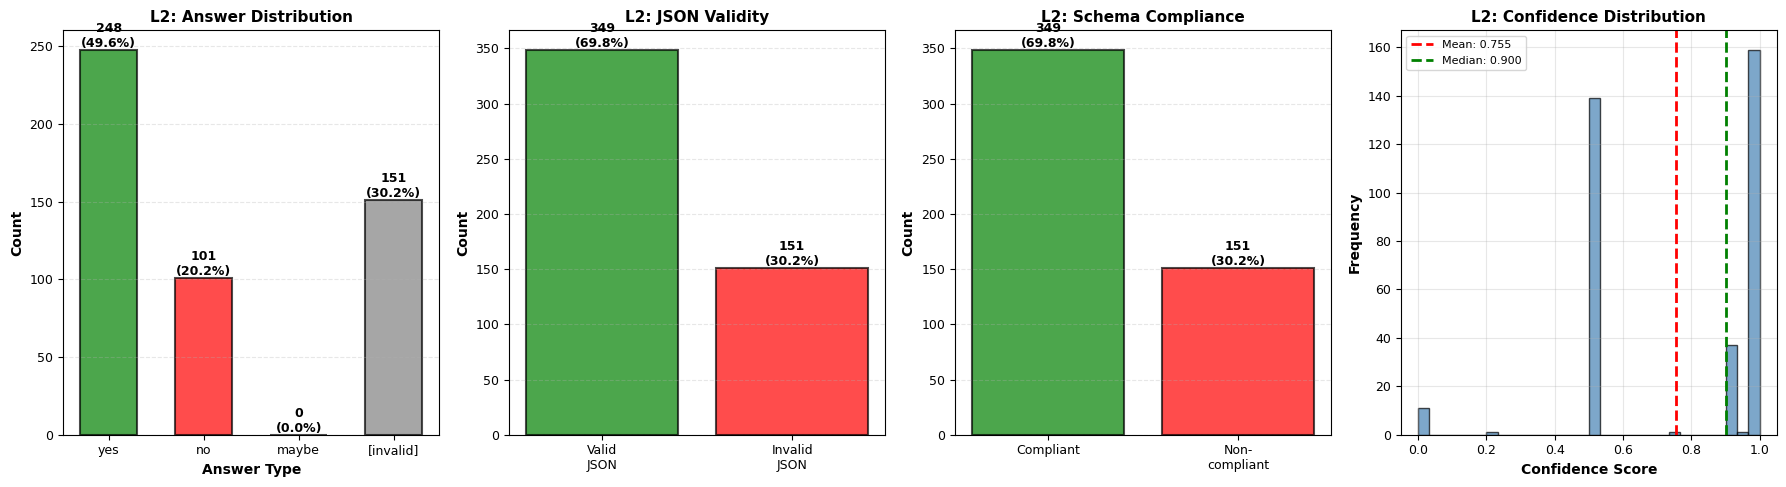

In [27]:
# Create visualizations for L2
fig = plt.figure(figsize=(18, 5))
axes = fig.subplots(1, 4)

# 1. Answer Distribution
ax1 = axes[0]
# Re-verify data
l2_answer_counts_verify = Counter(l2_answers)
l2_categories_plot = ['yes', 'no', 'maybe', '[invalid]']
l2_counts_plot = [l2_answer_counts_verify.get(cat, 0) for cat in l2_categories_plot]

x_pos = np.arange(len(l2_categories_plot))
bars1 = ax1.bar(x_pos, l2_counts_plot, color=['green', 'red', 'orange', 'gray'], alpha=0.7, edgecolor='black', linewidth=1.5, width=0.6)
for bar, count in zip(bars1, l2_counts_plot):
    height = bar.get_height()
    percentage = count / l2_total * 100 if l2_total > 0 else 0
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.set_xlabel('Answer Type', fontsize=10, fontweight='bold')
ax1.set_ylabel('Count', fontsize=10, fontweight='bold')
ax1.set_title('L2: Answer Distribution', fontsize=11, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(l2_categories_plot, fontsize=9)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.tick_params(labelsize=9)

# 2. JSON Validity
ax2 = axes[1]
valid_count = l2_valid_json_count
invalid_count = l2_total - l2_valid_json_count
bars2 = ax2.bar(['Valid\nJSON', 'Invalid\nJSON'], [valid_count, invalid_count], 
                color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars2, [valid_count, invalid_count]):
    height = bar.get_height()
    percentage = count / l2_total * 100 if l2_total > 0 else 0
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax2.set_ylabel('Count', fontsize=10, fontweight='bold')
ax2.set_title('L2: JSON Validity', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=9)

# 3. Schema Compliance
ax3 = axes[2]
compliant_count = l2_compliant
non_compliant_count = l2_total - l2_compliant
bars3 = ax3.bar(['Compliant', 'Non-\ncompliant'], [compliant_count, non_compliant_count],
                color=['green', 'red'], alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, count in zip(bars3, [compliant_count, non_compliant_count]):
    height = bar.get_height()
    percentage = count / l2_total * 100 if l2_total > 0 else 0
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')
ax3.set_ylabel('Count', fontsize=10, fontweight='bold')
ax3.set_title('L2: Schema Compliance', fontsize=11, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.tick_params(labelsize=9)

# 4. Confidence Distribution
ax4 = axes[3]
if l2_valid_confidences:
    ax4.hist(l2_valid_confidences, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax4.axvline(np.mean(l2_valid_confidences), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {np.mean(l2_valid_confidences):.3f}')
    ax4.axvline(np.median(l2_valid_confidences), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {np.median(l2_valid_confidences):.3f}')
    ax4.set_xlabel('Confidence Score', fontsize=10, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax4.set_title('L2: Confidence Distribution', fontsize=11, fontweight='bold')
    ax4.legend(fontsize=8)
    ax4.grid(alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'No valid\nconfidence scores', 
            ha='center', va='center', transform=ax4.transAxes, fontsize=11)
    ax4.set_title('L2: Confidence Distribution', fontsize=11, fontweight='bold')
ax4.tick_params(labelsize=9)

plt.tight_layout()
plt.show()


## Baseline vs L1 vs L2 Comparison


In [29]:
# Compare Baseline, L1, and L2
print("="*80)
print("BASELINE vs L1 vs L2 COMPARISON")
print("="*80)

print(f"\n📊 Task Performance (Exact Match):")
print(f"   Baseline: {exact_match_score:.4f} ± {exact_match_stderr:.4f} ({exact_match_score*100:.2f}%)")
if l1_exact_match is not None:
    print(f"   L1:       {l1_exact_match:.4f} ± {l1_exact_match_stderr:.4f} ({l1_exact_match*100:.2f}%)")
if l2_exact_match is not None:
    print(f"   L2:       {l2_exact_match:.4f} ± {l2_exact_match_stderr:.4f} ({l2_exact_match*100:.2f}%)")

print(f"\n📈 Answer Distribution:")
print(f"   {'Metric':<20} {'Baseline':<15} {'L1':<15} {'L2':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")
# Compute baseline counts directly from baseline_answers
baseline_answer_counts = Counter(baseline_answers)
baseline_categories = ['yes', 'no', 'maybe', '[invalid]']
baseline_counts = [baseline_answer_counts.get(cat, 0) for cat in baseline_categories]
for i, cat in enumerate(baseline_categories):
    baseline_pct = baseline_counts[i] / len(baseline_answers) * 100
    l1_pct = l1_counts[i] / l1_total * 100 if 'l1_total' in globals() else 0
    l2_pct = l2_counts[i] / l2_total * 100 if 'l2_total' in globals() else 0
    print(f"   {cat:<20} {baseline_pct:>6.2f}% ({baseline_counts[i]:>3d}) {l1_pct:>6.2f}% ({l1_counts[i] if 'l1_counts' in globals() else 0:>3d}) {l2_pct:>6.2f}% ({l2_counts[i]:>3d})")

print(f"\n🔍 Schema Compliance:")
if 'l1_valid_json_count' in globals():
    print(f"   L1 - Valid JSON: {l1_valid_json_count}/{l1_total} ({l1_valid_json_count/l1_total*100:.2f}%)")
    print(f"   L1 - Schema Compliant: {l1_compliant}/{l1_total} ({l1_compliant/l1_total*100:.2f}%)")
if 'l2_valid_json_count' in globals():
    print(f"   L2 - Valid JSON: {l2_valid_json_count}/{l2_total} ({l2_valid_json_count/l2_total*100:.2f}%)")
    print(f"   L2 - Schema Compliant: {l2_compliant}/{l2_total} ({l2_compliant/l2_total*100:.2f}%)")
    print(f"   L2 - Confidence scores: {len(l2_valid_confidences)} valid")

print(f"\n💡 Key Insights:")
if l2_exact_match is not None:
    if l2_exact_match > exact_match_score:
        improvement = l2_exact_match - exact_match_score
        print(f"   ✅ L2 schema improves performance by {improvement*100:.2f} percentage points over baseline")
    elif l2_exact_match < exact_match_score:
        print(f"   ⚠️  L2 schema decreases performance by {abs(l2_exact_match - exact_match_score)*100:.2f} percentage points")
if 'l2_valid_json_count' in globals():
    print(f"   • L2 has {l2_valid_json_count/l2_total*100:.2f}% valid JSON (schema-constrained output)")
    print(f"   • L2 has {l2_compliant/l2_total*100:.2f}% schema compliance")
    if l2_valid_confidences:
        print(f"   • L2 confidence scores: mean={np.mean(l2_valid_confidences):.3f}, range=[{np.min(l2_valid_confidences):.3f}, {np.max(l2_valid_confidences):.3f}]")
print("="*80)


BASELINE vs L1 vs L2 COMPARISON

📊 Task Performance (Exact Match):
   Baseline: 0.7620 ± 0.0191 (76.20%)
   L1:       0.5480 ± 0.0223 (54.80%)
   L2:       0.5480 ± 0.0223 (54.80%)

📈 Answer Distribution:
   Metric               Baseline        L1              L2             
   -------------------- --------------- --------------- ---------------
   yes                   68.80% (344)  49.60% (248)  49.60% (248)
   no                    30.20% (151)  20.20% (101)  20.20% (101)
   maybe                  0.40% (  2)   0.00% (  0)   0.00% (  0)
   [invalid]              0.60% (  3)  30.20% (151)  30.20% (151)

🔍 Schema Compliance:
   L1 - Valid JSON: 349/500 (69.80%)
   L1 - Schema Compliant: 349/500 (69.80%)
   L2 - Valid JSON: 349/500 (69.80%)
   L2 - Schema Compliant: 349/500 (69.80%)
   L2 - Confidence scores: 349 valid

💡 Key Insights:
   ⚠️  L2 schema decreases performance by 21.40 percentage points
   • L2 has 69.80% valid JSON (schema-constrained output)
   • L2 has 69.80% schema c

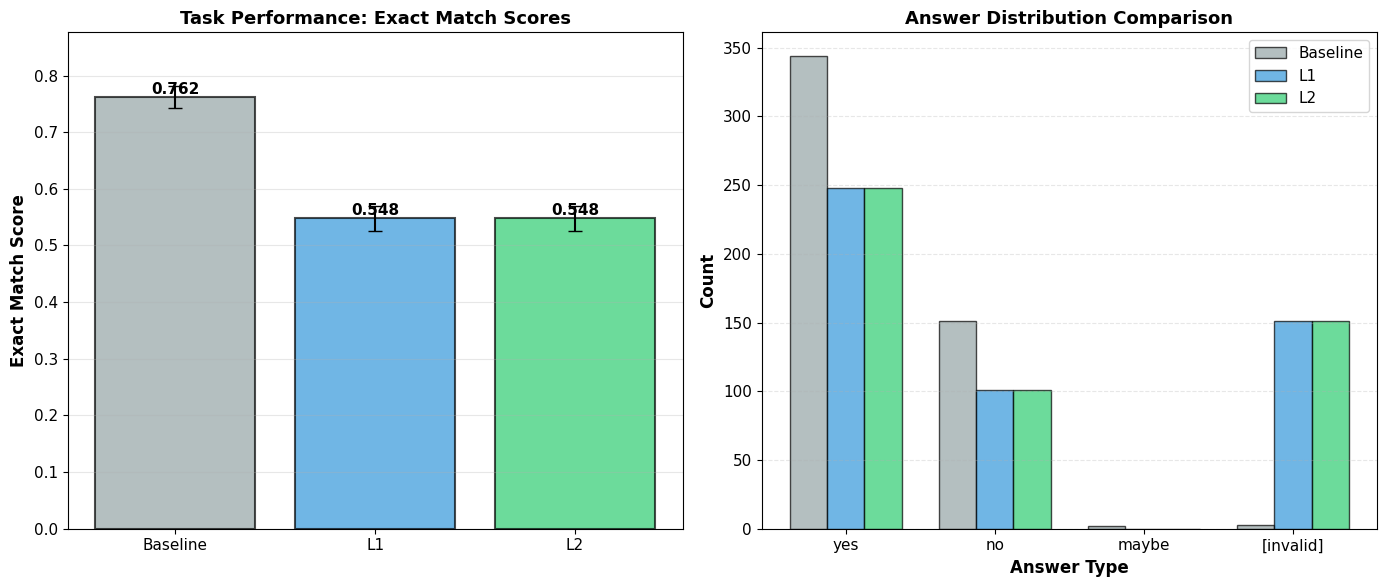

In [30]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Exact Match Score Comparison
ax1 = axes[0]
scores_list = [exact_match_score]
stderrs_list = [exact_match_stderr]
labels_list = ['Baseline']
colors_list = ['#95a5a6']

if l1_exact_match is not None:
    scores_list.append(l1_exact_match)
    stderrs_list.append(l1_exact_match_stderr)
    labels_list.append('L1')
    colors_list.append('#3498db')

if l2_exact_match is not None:
    scores_list.append(l2_exact_match)
    stderrs_list.append(l2_exact_match_stderr)
    labels_list.append('L2')
    colors_list.append('#2ecc71')

x_pos = np.arange(len(labels_list))
bars = ax1.bar(x_pos, scores_list, yerr=stderrs_list, capsize=5, color=colors_list, alpha=0.7, edgecolor='black', linewidth=1.5)
for bar, score in zip(bars, scores_list):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
ax1.set_ylabel('Exact Match Score', fontsize=12, fontweight='bold')
ax1.set_title('Task Performance: Exact Match Scores', fontsize=13, fontweight='bold')
if scores_list:
    ax1.set_ylim(0, max(scores_list) * 1.15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(labels_list, fontsize=11)
ax1.grid(alpha=0.3, axis='y')
ax1.tick_params(labelsize=11)

# 2. Answer Distribution Comparison
ax2 = axes[1]
x = np.arange(len(l2_categories))
width = 0.25

# Re-verify baseline data
baseline_counts_verify = [Counter(baseline_answers).get(cat, 0) for cat in l2_categories]
l1_counts_verify = [Counter(l1_answers).get(cat, 0) for cat in l2_categories] if 'l1_answers' in globals() else [0]*4
l2_counts_verify = [Counter(l2_answers).get(cat, 0) for cat in l2_categories]

bars1 = ax2.bar(x - width, baseline_counts_verify, width, label='Baseline', color='#95a5a6', alpha=0.7, edgecolor='black')
if 'l1_answers' in globals():
    bars2 = ax2.bar(x, l1_counts_verify, width, label='L1', color='#3498db', alpha=0.7, edgecolor='black')
bars3 = ax2.bar(x + width, l2_counts_verify, width, label='L2', color='#2ecc71', alpha=0.7, edgecolor='black')

ax2.set_xlabel('Answer Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Answer Distribution Comparison', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(l2_categories)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.tick_params(labelsize=11)

plt.tight_layout()
plt.show()
